In [1]:
import networkx as nx
import numpy as np

import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

from rostok.graph_grammar.node_vocabulary import NodeVocabulary
from rostok.graph_grammar.rule_vocabulary import RuleVocabulary
from rostok.graph_grammar.node import GraphGrammar


/home/human/anaconda3/envs/rostok_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import learning_rules
rule_vovabulary = learning_rules.init_extension_rules()


In [3]:
def vocabulary2batch_graph(rule_vocabulary: RuleVocabulary, max_rules: int):

    batch_graph = GraphGrammar()
    amount_rules = np.random.randint(1, max_rules)
    for _ in range(amount_rules):
        rules = rule_vocabulary.get_list_of_applicable_rules(batch_graph)
        if len(rules) > 0:
            rule = rule_vocabulary.get_rule(rules[np.random.choice(len(rules))])
            batch_graph.apply_rule(rule)
        else:
            break
    return batch_graph


In [4]:
class OneHotEncodding:
    def __init__(self, node_vocalubary: NodeVocabulary):
        
        self.label2node = node_vocalubary.node_dict
        self.id2label, self.label2id = self._create_dict_node_labels(node_vocalubary)
        
    def _create_dict_node_labels(self, node_vocabulary: NodeVocabulary) -> tuple[dict[int, str], dict[str, int]]:
        
        sorted_node_labels = sorted(node_vocabulary.node_dict.keys())

        dict_id_label_nodes = dict(enumerate(sorted_node_labels))
        dict_label_id_nodes = {label: idx for (idx, label) in enumerate(sorted_node_labels)}

        return dict_id_label_nodes, dict_label_id_nodes
    
    def _flatting_sorted_graph(self, graph: GraphGrammar) -> tuple[list[int], list[list[int]]]:
    
        sorted_id_nodes = list(nx.lexicographical_topological_sort(
        graph, key=lambda x: graph.get_node_by_id(x).label))
        sorted_name_nodes = list(map(lambda x: graph.get_node_by_id(x).label, sorted_id_nodes))

        id_node2list = {id[1]: id[0] for id in enumerate(list(sorted_id_nodes))}

        list_edges_on_id = list(graph.edges)
        list_id_edge_links = list(map(lambda x: [id_node2list[n] for n in x], list_edges_on_id))
        
        
        return sorted_name_nodes, list_id_edge_links
    
    def one_hot_encodding(self, label_node: str) -> list[int]:
        
        one_hot = np.zeros(len(self.label2id), dtype=int)
        one_hot[self.label2id[label_node]] = 1
        return one_hot.tolist()
    
    def transform_digraph(self, graph: GraphGrammar):
        
        node_label_list, edge_id_list = self._flatting_sorted_graph(graph)
        
        one_hot_list = list(map(self.one_hot_encodding, node_label_list))
        
        edge_index = torch.t(torch.tensor(edge_id_list, dtype=torch.long))
        x = torch.tensor(one_hot_list, dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index)
        
        return data


In [5]:

def create_train_valid_data(rule_vocabulary: RuleVocabulary, one_hot_encodding: OneHotEncodding, amount_graph: int, pseudo_length_graph: int):
    train_data = []
    for __ in range(round(amount_graph*0.8)):
        flatted_graph = []
        graph = vocabulary2batch_graph(rule_vocabulary, pseudo_length_graph)
        data_graph = one_hot_encodding.transform_digraph(graph)
        train_data.append(data_graph)
    train_data = DataLoader(train_data)
    valid_data = []
    for __ in range(round(amount_graph*0.2)):
        flatted_graph = []
        graph = vocabulary2batch_graph(rule_vocabulary, pseudo_length_graph)
        data_graph = one_hot_encodding.transform_digraph(graph)
        valid_data.append(data_graph)
    valid_data = DataLoader(valid_data)
    return train_data, valid_data

In [6]:
one_hot = OneHotEncodding(rule_vovabulary.node_vocab)
graph = vocabulary2batch_graph(rule_vovabulary, 3)
data = one_hot.transform_digraph(graph)

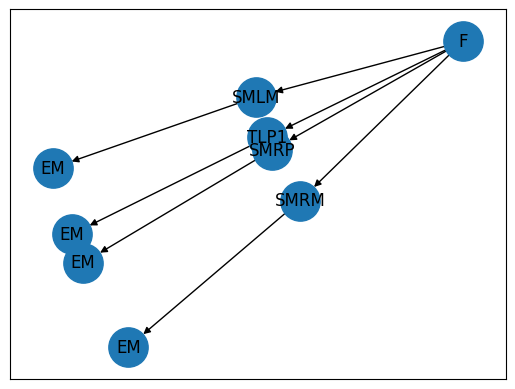

In [7]:
learning_rules.plot_graph(graph)

In [8]:
data.edge_index.shape

torch.Size([2, 8])

In [9]:
data

Data(x=[9, 54], edge_index=[2, 8])

In [10]:
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GAE

In [11]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

In [24]:
one_hot = OneHotEncodding(rule_vovabulary.node_vocab)
train_data, valid_data = create_train_valid_data(rule_vovabulary, one_hot, 1000, 10)

In [25]:
# parameters
out_channels = 2
num_features = train_data.dataset[0].num_features
epochs = 100

data = train_data.dataset[0]
# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
edge_index = data.edge_index.to(device)
print(x.shape, edge_index.shape)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

torch.Size([7, 54]) torch.Size([2, 6])


In [28]:
def train(data_train):
    model.train()
    for data in data_train.dataset:
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        optimizer.zero_grad()
        z = model.encode(x, edge_index)
        loss = model.recon_loss(z, edge_index)
        #if args.variational:
        #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        optimizer.step()
    return float(loss)


def test(valid_data):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, edge_index)
        auc, ap = model.test(z, edge_index, -edge_index)
    return auc, ap

In [29]:
for epoch in range(1, epochs + 1):
    loss = train(train_data)

    auc, ap = test(valid_data)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

/opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/cuda/Indexing.cu:1088: indexSelectSmallIndex: block: [0,0,0], thread: [0,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/cuda/Indexing.cu:1088: indexSelectSmallIndex: block: [0,0,0], thread: [1,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/cuda/Indexing.cu:1088: indexSelectSmallIndex: block: [0,0,0], thread: [2,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/cuda/Indexing.cu:1088: indexSelectSmallIndex: block: [0,0,0], thread: [3,0,0] Assertion `srcIndex < srcSelectDimSize` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.